In [ ]:
!pip install datasets

In [1]:
import torch
import re
import torch.nn.functional as F
import re
import numpy as np
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.output_vectors = nn.Embedding(vocab_size, embedding_size)

    def forward(self, X):
        #embeddings = self.embedding(x)
        #output = self.output_layer(embeddings)

        return self.embeddings(X)

In [12]:
from datasets import load_dataset

class WordsDataset(torch.utils.data.Dataset):
    
    def __init__(self, context_window):
        self.dataset = load_dataset('large_spanish_corpus', name='all_wikis', split='train')[:300000]
        self.tokenizer = get_tokenizer('basic_english')

        self.count_words()

        self.vocab = build_vocab_from_iterator(map(self.tokenizer, self.dataset['text']), specials=['<unk>'], min_freq=1, max_tokens=90000)
        self.vocab.set_default_index(self.vocab["<unk>"])

        self.context_window = context_window
        self.temperature = 10e-5

        print(f'Len of vocab {len(self.vocab)}')

        self.build_dataset()

    def count_words(self):
        self.freq = {}
        for document in self.dataset['text']:
            document = re.sub('[^A-Za-z0-9áéíóúñÁÉÍÓÚÑ]+', ' ', document)
            tokens = self.tokenizer(document)
    
            for word in tokens:
                if word in self.freq:
                    self.freq[word] += 1
                else:
                    self.freq[word] = 1

        self.total= sum(self.freq.values())

    def build_dataset(self):
        self.X = []
        self.y = []

        for document in self.dataset['text']:
          document = re.sub('[^A-Za-z0-9áéíóúñÁÉÍÓÚÑ]+', ' ', document)
          tokens = self.tokenizer(document)

          for i, word in enumerate(tokens):
              center = word

              if i < self.context_window:
                  continue
              elif i > len(tokens) - self.context_window - 1:
                  continue
              else:
                  context = tokens[i - self.context_window:i] + tokens[i + 1:i + self.context_window + 1]

              for word in context:
                subsample_probability = 1 - np.sqrt(self.temperature / (self.freq[center] / self.total))

                if np.random.rand() < subsample_probability:
                    continue

                if self.vocab[center] == self.vocab["<unk>"] or self.vocab[word] == self.vocab["<unk>"]:
                    continue

                self.X.append(self.vocab([center, word]))
                self.y.append(1)

                if len(self.X) % 1000000 == 0:
                    print(f'Center: {center} - Context: {word}')

        self.X = torch.tensor(self.X).long()
        self.y = torch.tensor(self.y).squeeze().long()

        print(self.X.shape)
        print(self.y.shape)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
embedding_size = 128
context_window = 3
batch_size = 1024
k = 10

In [14]:
from torch.utils.data import DataLoader

word_dataset = WordsDataset(context_window)
dataloader = DataLoader(word_dataset, batch_size=batch_size, shuffle=True)

print(f'Number of samples: {len(word_dataset.dataset["text"])}')

Found cached dataset large_spanish_corpus (/home/angel/.cache/huggingface/datasets/large_spanish_corpus/all_wikis/1.1.0/866aa19decb2ee81eed3e918e7150937330cc993815e36beda5f40a992058639)


Len of vocab 90000
Center: entre - Context: de
Center: protocolos - Context: los
Center: lado - Context: el
Center: nombres - Context: se
Center: cada - Context: cumplir
Center: x - Context: nc
Center: torbellino - Context: conocimientos
Center: microscopio - Context: la
torch.Size([8437155, 2])
torch.Size([8437155])
Number of samples: 300000


In [15]:
V = nn.Embedding(len(word_dataset.vocab), embedding_size).to(device)
U = nn.Embedding(len(word_dataset.vocab), embedding_size).to(device)

optimizer = torch.optim.Adam(list(V.parameters()) + list(U.parameters()), lr=0.001)

In [16]:
for batch, (X, y) in enumerate(dataloader):
    X = X.squeeze().to(device)
    y = y.squeeze().to(device)

    print(X.shape)
    print(y.shape)

    break

torch.Size([1024, 2])
torch.Size([1024])


In [17]:
center = V(X[:, 0])
context = U(X[:, 1])

negative_samples_indices = torch.randint(0, len(word_dataset.vocab), (k, 1)).squeeze().to(device)
negative_samples = U(negative_samples_indices)
    
loss = -torch.sum(torch.log(torch.sigmoid(torch.diagonal(torch.matmul(center, context.T))))) - torch.sum(torch.log(torch.sigmoid(-torch.diagonal(torch.matmul(center, negative_samples.T)))))
loss = loss / X.shape[0]

loss

tensor(4.5062, device='cuda:0', grad_fn=<DivBackward0>)

In [18]:
for i in range(X.shape[0]):
    center = word_dataset.vocab.lookup_token(X[i, 0].item())
    context =  word_dataset.vocab.lookup_token(X[i, 1].item())

    print(f'Center: {center} - Context: {context}')


Center: empotrados - Context: los
Center: iec - Context: norma
Center: y - Context: tiene
Center: haciendas - Context: plantaciones
Center: sustantivo - Context: del
Center: domicilio - Context: el
Center: trabaja - Context: viga
Center: es - Context: conocidos
Center: llevara - Context: desde
Center: licencia - Context: abierta
Center: milo - Context: mil
Center: desde - Context: base
Center: pasar - Context: 2
Center: disciplina - Context: como
Center: papel - Context: profesor
Center: vista - Context: nunca
Center: estuvieron - Context: varias
Center: aquello - Context: superior
Center: mientras - Context: trate
Center: velocidad - Context: incremento
Center: 450 - Context: las
Center: cocida - Context: al
Center: inevitable - Context: cual
Center: al - Context: y
Center: unas - Context: que
Center: he - Context: la
Center: representantes - Context: los
Center: latinoamericanos - Context: escribir
Center: modificaciones - Context: y
Center: adolfo - Context: de
Center: resultado - C

In [ ]:
for epoch in range(5):
    # Compute prediction error
    center = V(X[:, 0])
    context = U(X[:, 1])

    negative_samples_indices = torch.randint(0, len(word_dataset.vocab), (k, 1)).squeeze().to(device)
    negative_samples = U(negative_samples_indices)

    loss = -torch.sum(torch.log(torch.sigmoid(torch.diagonal(torch.matmul(center, context.T))))) - torch.sum(torch.log(torch.sigmoid(-torch.diagonal(torch.matmul(center, negative_samples.T)))))
    loss = loss / X.shape[0]
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)

      print(f"epoch {epoch} loss: {loss:>7f}  [{current:>5d}/{len(word_dataset):>5d}]")

In [19]:
for epoch in range(30):
  for batch, (X, y) in enumerate(dataloader):
    X = X.squeeze().to(device)
    y = y.squeeze().to(device)

    # Compute prediction error
    center = V(X[:, 0])
    context = U(X[:, 1])

    negative_samples_indices = torch.randint(0, len(word_dataset.vocab), (k, 1)).squeeze().to(device)
    negative_samples = U(negative_samples_indices)
        
    loss = -torch.sum(torch.log(torch.sigmoid(torch.diagonal(torch.matmul(center, context.T))))) - torch.sum(torch.log(torch.sigmoid(-torch.diagonal(torch.matmul(center, negative_samples.T)))))
    loss = loss / X.shape[0]

    # Backpropagation
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()

    if batch % 1000 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      accuracy = torch.sum(torch.sigmoid(torch.diagonal(torch.matmul(center, context.T))) > 0.5) / X.shape[0]

      print(f"epoch {epoch} loss: {loss:>7f}  [{current:>5d}/{len(word_dataset):>5d}] accuracy: {accuracy:>7f}")


epoch 0 loss: 4.579383  [ 1024/8437155] accuracy: 0.483398
epoch 0 loss: 3.612124  [1025024/8437155] accuracy: 0.534180
epoch 0 loss: 2.873606  [2049024/8437155] accuracy: 0.595703
epoch 0 loss: 2.529804  [3073024/8437155] accuracy: 0.650391
epoch 0 loss: 2.084288  [4097024/8437155] accuracy: 0.707031
epoch 0 loss: 1.742670  [5121024/8437155] accuracy: 0.760742
epoch 0 loss: 1.522073  [6145024/8437155] accuracy: 0.768555
epoch 0 loss: 1.255634  [7169024/8437155] accuracy: 0.818359
epoch 0 loss: 1.043963  [8193024/8437155] accuracy: 0.830078
epoch 1 loss: 0.870199  [ 1024/8437155] accuracy: 0.854492
epoch 1 loss: 0.809552  [1025024/8437155] accuracy: 0.870117
epoch 1 loss: 0.601080  [2049024/8437155] accuracy: 0.886719
epoch 1 loss: 0.647873  [3073024/8437155] accuracy: 0.907227
epoch 1 loss: 0.688797  [4097024/8437155] accuracy: 0.890625
epoch 1 loss: 0.548144  [5121024/8437155] accuracy: 0.923828
epoch 1 loss: 0.467487  [6145024/8437155] accuracy: 0.925781
epoch 1 loss: 0.389720  [716

In [20]:
words = word_dataset.vocab(['rey', 'hombre', 'mujer', 'reina'])
print(words)

words_tensor = torch.tensor(words).to(device)
embeddings = V(words_tensor)

analogy_vector = embeddings[1] - embeddings[0] + embeddings[2]

embedding_matrix = torch.clone(V.weight)
embedding_matrix[words[:-1], :] = 0

result = torch.argmax(torch.matmul(embedding_matrix, analogy_vector))
print(result)
word_dataset.vocab.lookup_token(result.item())

[1425, 635, 887, 9710]
tensor(17337, device='cuda:0')


'conversar'

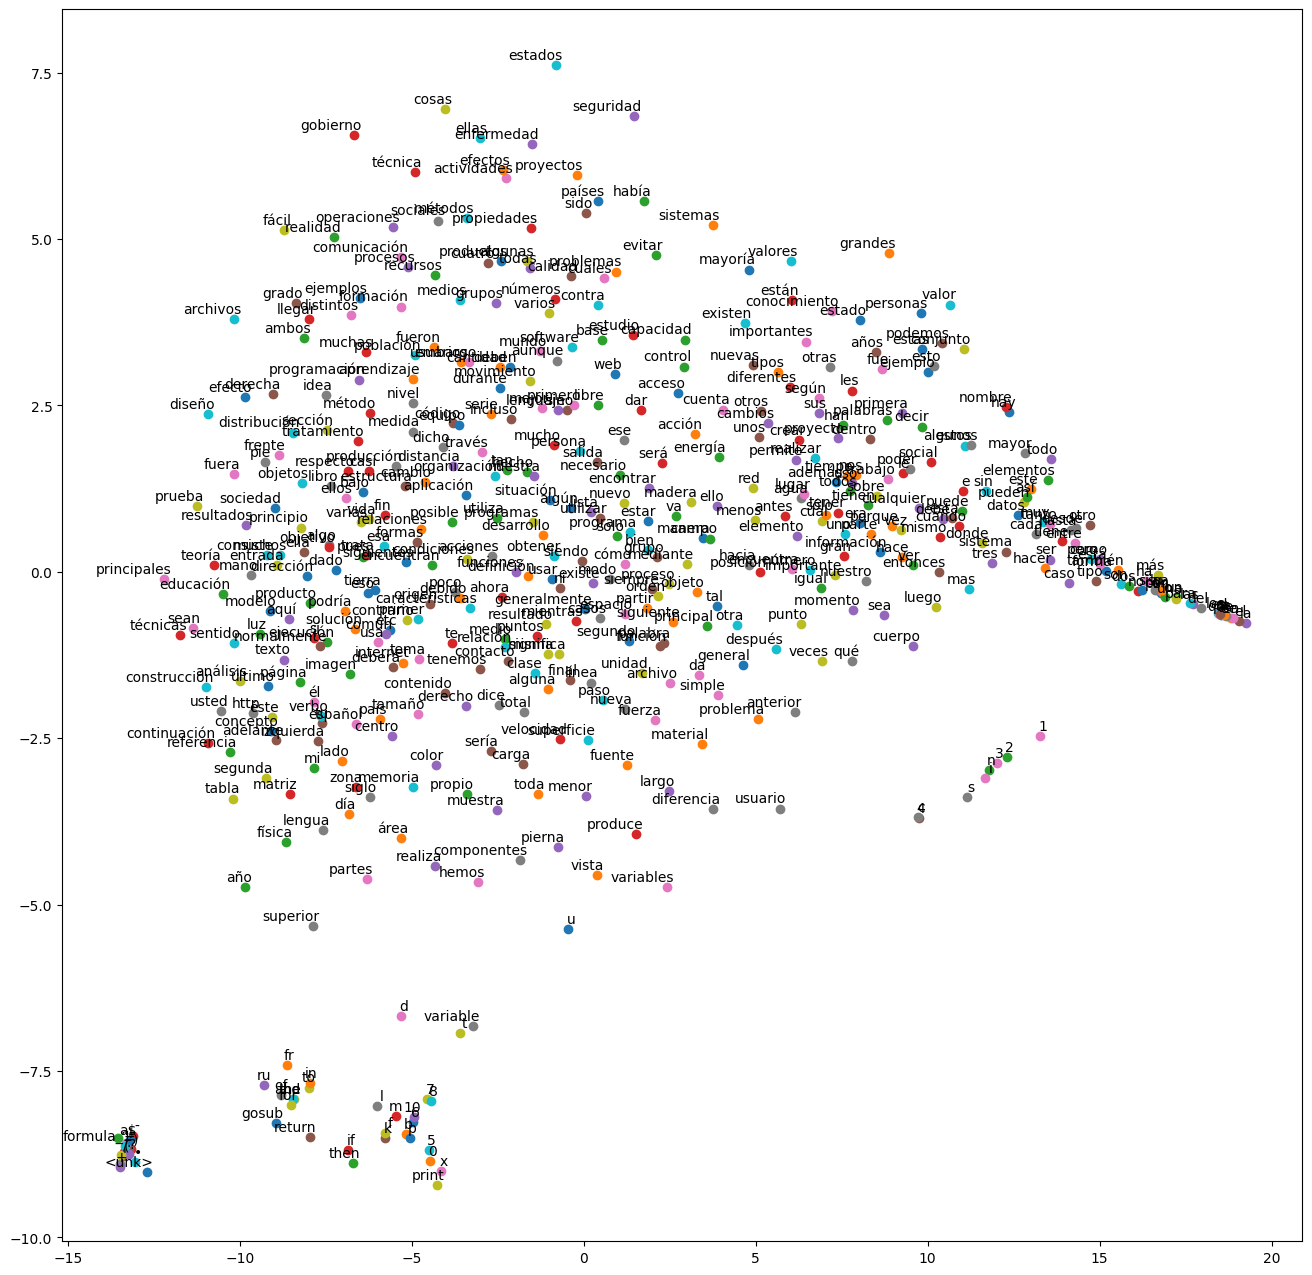

In [23]:
# visualize embeddings of the first 1000 words
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
embeddings = tsne.fit_transform(U.weight.detach().cpu().numpy()[:500, :])

plt.figure(figsize=(16, 16))
for i, label in enumerate(word_dataset.vocab.lookup_token(idx) for idx in range(500)):
    x, y = embeddings[i, :]

    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.show()  
